## Incorporating Neural Networks

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

Neural networks have become exceedingly popular recently due, in part, to their ability to achieve state-of-the-art performance on a variety of tasks without requiring complicated feature extraction pipelines. These models are frequently applied to domains where there is a great deal of raw structured data, such as computer vision, where neighboring pixels are strongly correlated, and natural language processing, where words are organized and modified in specific ways to convey meaning.

There have been mergers between neural networks and probabilistic models. For example, deep hidden Markov models (DHMMs) are models where the input to the neural network is some observation, such as an image, and the output is the state in the hidden Markov model that the observation belongs to. These resulting probabilities are then treated as the likelihood function P(D|M) by the model, regularized using the transition matrix, and then re-normalized to get the posterior probabilities. Another example is a deep mixture model, where expectation-maximization is used to train the model on unlabeled samples.

Thus far, pomegranate has stuck to probabilistic models that are not coupled with a neural network. However, with the recent inclusion of custom distributions, one can use a quick hack in order to turn pomegranate's models into deep models.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import seaborn; seaborn.set_style('whitegrid')

from pomegranate import *

numpy.random.seed(0)

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate

Fri Feb 15 2019 

numpy 1.15.1
scipy 1.1.0
pomegranate 0.10.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.15.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


### What?

Two natural questions emerge when considering the notion of combining a neural network and a probabilistic model. The first is: what is the benefit? The second: how does one do that?

There are many benefits of merging a neural network and a probabilistic model. The simplest is that one can expand the expressiveness of probabilistic models by incorporating a neural network. Instead of forcing your data to come neatly in the form of a single distribution or a mixture of distributions, one can process data that comes in more structured forms such as images. Additionally, a neural network may be able to extract more complicated relationships amongst the features of existing data sets than a simple covariance matrix could.

Practically, this works by having a single neural network replace the entire set of distributions in your model where the model has the same number of outputs as probability distributions that used to be in your model. For example, a HMM that has eight states would be coupled with a neural network that makes predictions for eight classes. First, each observation in your sequence would be run through the neural network to get the predictions for each observation. This calculation is essentially the same as calculating the probability of an observation given each state and then normalizing, i.e., taking a softmax. 

### The Neural Network Wrapper

We can hack pomegranate models by using a custom distribution that wraps our neural network (using the package of your choice). The following class will store a pointer to your model, an identifying of which class it's representing, and train or make predictions using the given class. When asked for a log probability, it returns the posterior probability of the observation given the class it's storing. When training, it stores data and labels (it's own class ID) and then performs a single round of training to update. Note that this is the exact code that is already implemented in pomegranate, except this version is called "NeuralNetworkWrapperExample" instead of "NeuralNetworkWrapper", and is only shown here for reference as to what's going on in the backend.

In [2]:
class NeuralNetworkWrapperExample():
    '''A wrapper for a neural network model for use in pomegranate.
    
    This wrapper will store a pointer to the model, as well as an indicator
    of what class it represents. It needs information about the number of
    dimensions of the input and the total number of classes in the input.
    It is currently built to work with keras models, but can be easily
    modified to work with the package of your choice.
    
    Training works in a somewhat hacky manner. Internally, pomegranate
    will scan over all components of the model, calling `summarize` for each
    one, and then `from_summaries` at the end. During the EM procedure, the
    samples and their associated weights are passed in to the `summarize`
    function. The associated weights are the responsibilities calculated
    during the EM algorithm. In theory, one could simply update the model
    using the samples and their corresponding weights. In practice, it's much
    better to reconstruct the whole responsibility matrix for the batch of
    data and then train on soft labels.
    
    The process for training is as follows. When pomegranate starts a round of
    optimization, this wrapper will store a pointer to the data set to the
    neural network model object. This data set is the same one passed to each
    NeuralNetworkWrapper, the only difference being the ~weights~. Thus, each
    successive call will store the weights that are passed in (the responsibilities
    from the EM algorithm) to an associated label matrix. The result is a single
    copy of the data batch and a corresponding matrix of soft labels. Keras
    allows us to train a classifier on soft labels, and this is the preferred
    strategy.
    
    Parameters
    ----------
    model : object
        The neural network model being utilized.
        
    i : int
        The class that this distribution represents.
    
    n_dimensions : int
        The number of dimensions in the input.
    
    n_classes : int
        The total number of classes that the model can output.
    '''
    
    def __init__(self, model, i, n_dimensions, n_classes):
        self.d = n_dimensions
        self.n_classes = n_classes
        self.model = model
        self.i = i
        self.model.X = []
        self.model.y = []
        self.model.w = []
    
    def log_probability(self, X):
        ''' Return pseudo-log probabilities from the neural network.
        
        This method returns the log probability of the class that this
        wrapper represents given the model. Thus, it's not strictly a
        likelihood function, but rather, a posterior. However, because
        the HMM takes log probabilities, multiplies them with a prior,
        and then normalizes them, mathematically they work out to be
        equivalent.

        This method uses the `predict` function from the neural network,
        which should take in a single batch of data, and returns the
        posterior probability of each class given the network. Typically,
        this is calculated using a softmax function on the outputs. The
        output of this function should be a matrix of size (n, k), where
        n is the number of samples and k is the number of classes, where
        the sum over each sample is equal to 1. 

        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            The batch of data to calculcate probabilities over.
        '''
        
        return numpy.log(self.model.predict(X)[:,self.i])
    
    def summarize(self, X, w):
        '''When shown a batch of data, store the data.

        This will store the batch of data, and associated weights, to the
        object. The actual update occurs when `from_summaries` is called.

        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            The batch of data to be passed in.

        w : numpy.ndarray, shape=(n,)
            The associated weights. These can be uniform if unweighted.

        Returns
        -------
        None
        '''

        if self.i == 0:
            self.model.X = X.copy()
            self.model.y = numpy.zeros((X.shape[0], self.n_classes))
            
        self.model.y[:, self.i] = w
        
    def from_summaries(self, inertia=0.0):
        '''Perform a single gradient update to the network.

        This will perform a single gradient update step, using the
        `train_on_batch` method from the network. This is already implemented
        for keras networks, but for other networks this method will have to
        be implemented. It should take in a single batch of data, along with
        associated sample weights, and update the model weights.

        Parameters
        ----------
        inertia : double, optional
            This parameter is ignored for neural networks, but required for
            compatibility reasons.

        Returns
        -------
        None
        '''


        if self.i == 0:
            self.model.train_on_batch(self.model.X, self.model.y)
            self.clear_summaries()
    
    def clear_summaries(self):
        self.model.X = None
        self.model.y = None


    @classmethod
    def from_samples(self, X, weights):
        '''The training of this wrapper on data should be performed in the main model.

        This method should not be used directly to train the network.
        '''

        return self


### Deep mixture models

The first model we'll merge with a deep network is the general mixture model. Here, our neural network model can have any architecture as long as it outputs a number of classes equal to the number of components that you'd like in the mixture model. Our goal is to then train the neural network in an unsupervised manner using EM. This can be very difficult to do correctly and fragile, so use with care.

Let's demonstrate this on the MNIST handwritten digits data set, where we want to learn a model that can distinguish 2's from 9's without any training labels. 

In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[(y_train == 2) | (y_train == 9)]
X_test = X_test[(y_test == 2) | (y_test == 9)]
y_test = y_test[(y_test == 2) | (y_test == 9)]

n, d = X_train.shape[0], 784

X_train = X_train.reshape(n, d)
X_test = X_test.reshape(X_test.shape[0], d)

Using Theano backend.


Now, we have to implement the initialization step by hand because it's currently not built-in. First we use K-means to cluster the data and assign preliminary labels. Then, we train our neural network model for some amount of time on those labels. Lastly, we use EM to refine our labels just in case the initial K-means cluster was not good enough. This procedure is essentially identical to the built-in initialization for mixtures, with the only difference being that all the complexities of training a neural network replace the simplicity of fitting a probability distribution.

In [4]:
from sklearn.cluster import KMeans
from pomegranate import GeneralMixtureModel
from pomegranate import NeuralNetworkWrapper

from keras.layers import Dense
from keras.models import Sequential

numpy.random.seed(111)

# Use k-means to get an initial clustering of our data
y_init = KMeans(2).fit_predict(X_train)
y_kmeans = numpy.zeros((n, 2))
y_kmeans[numpy.arange(n), y_init] = 1

# Define the neural network model. Here we use a simple model for illustration. 
nn = Sequential([
    Dense(128, input_dim=d, activation='relu'), 
    Dense(2, activation='softmax')
])

nn.compile(loss='categorical_crossentropy', optimizer='adam')

# Now we fit to the k-means defined labels. 
nn.fit(X_train, y_kmeans, epochs=10, verbose=False)

# Here we define our wrappers---one for each component in our mixture / each class in our neural model
d1 = NeuralNetworkWrapper(nn, 0, d, 2)
d2 = NeuralNetworkWrapper(nn, 1, d, 2)

# We feed the wrapper into the mixture model as you would a normal distribution
model1 = GeneralMixtureModel([d1, d2])

# Now we fit the model using EM, just as one would with built-in distributions
model1.fit(X_train, max_iterations=10, stop_threshold=0.1)

# And make predictions just as one would with normal distributions
y_hat = model1.predict(X_test)

Let's take a look at the clusters that are found using this approach.

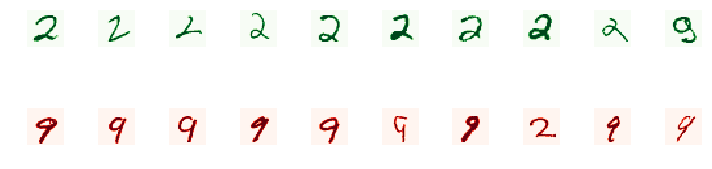

In [5]:
plt.figure(figsize=(10, 3))

X_test_r = X_test.reshape(X_test.shape[0], 28, 28)

for i in range(1, 11):
    plt.subplot(2, 10, i)
    plt.imshow(X_test_r[y_hat == 0][i], cmap='Greens')
    plt.axis('off')
    
    plt.subplot(2, 10, i+10)
    plt.imshow(X_test_r[y_hat == 1][i], cmap='Reds')
    plt.axis('off')

plt.tight_layout()

Looks good! One cluster clearly seems to be 2's, and one clearly appears to be 9's. 

But, how much of this was just because K-means did a good job of clustering MNIST, which is a notoriously easy data set? Well, we can evaluate that by seeing how good the predictions using K-means would be versus our deep mixture model. Let's print out the accuracy using the predicted labels, and those labels flipped, just because we don't know which cluster ends up corresponding to which original label when you use unsupervised methods for training.

In [6]:
y_kmeans_hat = KMeans(2).fit(X_train).predict(X_test)

y_test[y_test == 2] = 0
y_test[y_test == 9] = 1

print("kmeans: ", (y_kmeans_hat == y_test).mean(), ((1 - y_kmeans_hat) == y_test).mean())
print("deep mixture model: ", (y_hat == y_test).mean(), ((1 - y_hat) == y_test).mean())

('kmeans: ', 0.9608035276825085, 0.039196472317491425)
('deep mixture model: ', 0.9696227339539442, 0.030377266046055854)


It looks like we get a small improvement in performance. Now, MNIST is notoriously easy and one could likely get much better performance by tuning the K-means model. However, this does demonstrate that deep mixture models have potential for much larger and more complicated phenomena.

### Deep hidden Markov models

The next type of model we could merge with a neural network is a hidden Markov model. In this situation, the classes in the neural network correspond to hidden states in the HMM, and the edges in the HMM correspond to probabilistic constraints in the network predictions over a sequence.

To demonstrate how this would work we consider the situation in which one has a pre-trained object recognition network and wants to adapt it to work over videos (sequences of images) but doesn't have labels for each frame in their data. The goal is not to refine the network, which has been pre-trained, but to train the HMM such that it learns a useful transition matrix to constrain the predictions from the neural network alone applied to each frame sequentially.

Let's use the MNIST data set again, but this time use data from each of the 10 classes.

In [7]:
from keras.utils import to_categorical

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
y_train_ohe = to_categorical(y_train, num_classes=10)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

Because keras doesn't have any pre-trained MNIST models, let's pre-train some simple model on the training set and then freeze it. We use L2 regularization because unregularized dense networks with lots of parameters have a tendancy to predict probabilities of 1 rather than smooth probability distributions. 

In [8]:
from keras.regularizers import l2

# Define our neural network model. In this case it's a small dense network for fast training, but in
# practice it can be anything that has 10 classes as the output.
nn = Sequential([
    Dense(32, activation='relu', input_dim=784, kernel_regularizer=l2(1.)),
    Dense(10, activation='softmax')
])

nn.compile(loss='categorical_crossentropy', optimizer='adam')

# Now we fit our model to the data to get a "pre-trained" model
nn.fit(X_train, y_train_ohe, epochs=25, verbose=False, batch_size=256)

# After training we go through and freeze the model so that training our HMM later on doesn't affect the parameters
for layer in nn.layers:
    layer.trainable = False

nn.compile(loss='categorical_crossentropy', optimizer='adam')

Now we have to generate sequences from our training data of images. Our "videos" will be sequences of images, and we add structure by enforcing that the images are of digits that either stay the same value or increase. For example, a "video" might be images of the digits 1, 1, 2, and 5 sequentially, but not 1, 4, and 2 sequentially. Our goal is to train the HMM to learn this constraint.  

In [9]:
def generate_videos(X_train, y_train, n=1000):
    seqs, labels = [], []
    
    for _ in range(n):
        seq, label, number = [], [], 0
        
        # Our videos can be a maximum of 25 images
        for i in range(25):
            chance = numpy.random.choice(4)
            
            # There's a 25% chance that the next image skips a number, but only as long as it
            # stays between 1 and 10, e.g. 1 followed by a 3. 
            if chance == 2:
                if number < 8:
                    number += 2
                
            # There's a 25% chance that the next image proceeds to the next number, e.g. 1 followed by a 2
            elif chance == 3:
                if number < 9:
                    number += 1
            
            # There's a 50% chance that the next image is of the same number, e.g. 1 followed by a 1
            
            # If we've seen at least one image already, there's an independent 10% chance that
            # the sequence terminates to give us a distribution of sequence lengths
            if i > 1 and numpy.random.choice(10) == 9:
                break
            
            idx = numpy.random.randint((y_train == number).sum())
            seq.append(X_train[y_train == number][idx])
            label.append(number)
        
        labels.append(label)
        seqs.append(numpy.array(seq))
    
    return seqs, labels

X_train_seqs, y_train_seqs = generate_videos(X_train, y_train, 1000)
X_test_seqs, y_test_seqs = generate_videos(X_test, y_test, 100)

Next, let's hand define a model where you can either stay in the same hidden state of proceed to any of the next three states. In this case, a state corresponds to a number / class in the MNIST data set. If one doesn't have prior knowledge of what the transition structure should look like they can train the model similarly to the deep mixture model example above. However, this will allow us to see whether training the model using EM actually works to improve on rough hand-specified constraints.

In [10]:
d0 = NeuralNetworkWrapper(nn, 0, 28*28, 10)
d1 = NeuralNetworkWrapper(nn, 1, 28*28, 10)
d2 = NeuralNetworkWrapper(nn, 2, 28*28, 10)
d3 = NeuralNetworkWrapper(nn, 3, 28*28, 10)
d4 = NeuralNetworkWrapper(nn, 4, 28*28, 10)
d5 = NeuralNetworkWrapper(nn, 5, 28*28, 10)
d6 = NeuralNetworkWrapper(nn, 6, 28*28, 10)
d7 = NeuralNetworkWrapper(nn, 7, 28*28, 10)
d8 = NeuralNetworkWrapper(nn, 8, 28*28, 10)
d9 = NeuralNetworkWrapper(nn, 9, 28*28, 10)

s0 = State(d0, "s0")
s1 = State(d1, "s1")
s2 = State(d2, "s2")
s3 = State(d3, "s3")
s4 = State(d4, "s4")
s5 = State(d5, "s5")
s6 = State(d6, "s6")
s7 = State(d7, "s7")
s8 = State(d8, "s8")
s9 = State(d9, "s9")

model = HiddenMarkovModel()
model.add_states(s0, s1, s2, s3, s4, s5, s6, s7, s8, s9)
model.add_transition(model.start, s0, 0.33)
model.add_transition(model.start, s1, 0.33)
model.add_transition(model.start, s2, 0.34)

model.add_transition(s0, s0, 0.24)
model.add_transition(s0, s1, 0.24)
model.add_transition(s0, s2, 0.24)
model.add_transition(s0, s3, 0.24)
model.add_transition(s0, model.end, 0.04)

model.add_transition(s1, s1, 0.24)
model.add_transition(s1, s2, 0.24)
model.add_transition(s1, s3, 0.24)
model.add_transition(s1, s4, 0.24)
model.add_transition(s1, model.end, 0.04)

model.add_transition(s2, s2, 0.24)
model.add_transition(s2, s3, 0.24)
model.add_transition(s2, s4, 0.24)
model.add_transition(s2, s5, 0.24)
model.add_transition(s2, model.end, 0.04)
                    
model.add_transition(s3, s3, 0.24)
model.add_transition(s3, s4, 0.24)
model.add_transition(s3, s5, 0.24)
model.add_transition(s3, s6, 0.24)
model.add_transition(s3, model.end, 0.04)

model.add_transition(s4, s4, 0.24)
model.add_transition(s4, s5, 0.24)
model.add_transition(s4, s6, 0.24)
model.add_transition(s4, s7, 0.24)
model.add_transition(s4, model.end, 0.04)

model.add_transition(s5, s5, 0.24)
model.add_transition(s5, s6, 0.24)
model.add_transition(s5, s7, 0.24)
model.add_transition(s5, s8, 0.24)
model.add_transition(s5, model.end, 0.04)

model.add_transition(s6, s6, 0.24)
model.add_transition(s6, s7, 0.24)
model.add_transition(s6, s8, 0.24)
model.add_transition(s6, s9, 0.24)
model.add_transition(s6, model.end, 0.04)

model.add_transition(s7, s7, 0.25)
model.add_transition(s7, s8, 0.25)
model.add_transition(s7, s9, 0.25)
model.add_transition(s7, model.end, 0.25)

model.add_transition(s8, s8, 0.33)
model.add_transition(s8, s9, 0.33)
model.add_transition(s8, model.end, 0.34)

model.add_transition(s9, s9, 0.5)
model.add_transition(s9, model.end, 0.5)
model.bake()

Now we can make predictions using the maximum a posteriori (MAP) algorithm.

In [11]:
y_pred = numpy.concatenate([model.predict(seq) for seq in X_test_seqs])

Alternately, we could apply our pre-trained model to each image individually to make predictions. If our deep HMM model does not outperform this, there is no benefit to combining the neural network with a probabilistic model.

In [12]:
y_nn_pred = numpy.argmax(nn.predict(numpy.concatenate(X_test_seqs)), axis=1)

Let's evaluate our models using simple accuracy at predicting the value of each image.

In [13]:
y_true = numpy.concatenate(y_test_seqs)

print("pre-trained model: ", (y_nn_pred == y_true).mean())
print("deep HMM before training: ", (y_pred == y_true).mean())

('pre-trained model: ', 0.9231464737793852)
('deep HMM before training: ', 0.9792043399638336)


It looks like there is a significant improvement using the HMM, even before refinement of the transition matrix using EM. This is because there are predictions that the pre-trained neural network alone may have gotten incorrect, but when combined with the transition matrix the correct label became more likely. For example, there may be a situation where the model alone thought that a 0 came after a 3. However, our transition matrix says that that is impossible. Essentially, our HMM allows our model to consider context better. 

Now, what happens when we train the model? Remember that we froze our model, so this refinement is only done on the transition matrix of the HMM, not the parameters of the pre-trained neural network.

In [14]:
_ = model.fit(X_train_seqs, max_iterations=10, verbose=True)

[1] Improvement: 3167.82880474	Time (s): 7.191
[2] Improvement: 46.46103046	Time (s): 7.029
[3] Improvement: 5.49539624626	Time (s): 7.207
[4] Improvement: 1.37985857847	Time (s): 7.154
[5] Improvement: 0.488223125971	Time (s): 7.188
[6] Improvement: 0.211493207351	Time (s): 7.188
[7] Improvement: 0.103808710392	Time (s): 7.27
[8] Improvement: 0.0552500054655	Time (s): 7.145
[9] Improvement: 0.0311245813919	Time (s): 7.147
[10] Improvement: 0.018309211895	Time (s): 7.189
Total Training Improvement: 3222.07329887
Total Training Time (s): 78.8414


In [15]:
y_pred2 = numpy.concatenate([model.predict(seq) for seq in X_test_seqs])

print("pre-trained model: ", (y_nn_pred == y_true).mean())
print("deep HMM before training: ", (y_pred == y_true).mean())
print("deep HMM after training: ", (y_pred2 == y_true).mean())

('pre-trained model: ', 0.9231464737793852)
('deep HMM before training: ', 0.9792043399638336)
('deep HMM after training: ', 0.9855334538878843)


It looks like the addition of the constraints by themselves leads to a large improvement in performance, and that refining the transition matrix leads to further improvements. 

Even if we don't know the structure of the HMM beforehand we can still get good performance.

In [16]:
nn = Sequential([
    Dense(32, activation='relu', input_dim=784, kernel_regularizer=l2(1.)),
    Dense(10, activation='softmax')
])

nn.compile(loss='categorical_crossentropy', optimizer='adam')

nn.fit(X_train, y_train_ohe, epochs=25, verbose=False, batch_size=256)

for layer in nn.layers:
    layer.trainable = False

nn.compile(loss='categorical_crossentropy', optimizer='adam')
y_nn_pred = numpy.argmax(nn.predict(numpy.concatenate(X_test_seqs)), axis=1)

distributions = [NeuralNetworkWrapper(nn, i, 28*28, 10) for i in range(10)]

model = HiddenMarkovModel.from_samples(distributions, 10, X_train_seqs, max_iterations=10, verbose=True)
y_pred = numpy.concatenate([model.predict(seq) for seq in X_test_seqs])

print("pre-trained model: ", (y_nn_pred == y_true).mean())
print("deep HMM before training: ", (y_pred == y_true).mean())

[1] Improvement: 11385.6094235	Time (s): 6.5
[2] Improvement: 1495.15851959	Time (s): 6.434
[3] Improvement: 221.541352097	Time (s): 6.438
[4] Improvement: 36.4806422466	Time (s): 6.501
[5] Improvement: 8.603361119	Time (s): 6.425
[6] Improvement: 2.28461893309	Time (s): 6.604
[7] Improvement: 0.693117308972	Time (s): 6.444
[8] Improvement: 0.281554052133	Time (s): 6.427
[9] Improvement: 0.140599682802	Time (s): 6.488
[10] Improvement: 0.0812708375324	Time (s): 6.431
Total Training Improvement: 13150.8744594
Total Training Time (s): 71.1533
('pre-trained model: ', 0.918625678119349)
('deep HMM before training: ', 0.9819168173598554)


In a situation where one has labels for all images in a sequence, a recurrent neural network is likely to have superior performance to a HMM at this type of classification. However, when one doesn't have class labels, deep HMMs can be a very powerful tool.